A baseline version of state space models in Python is now ready as a pull request to the Statsmodels project, at https://github.com/statsmodels/statsmodels/pull/1698. Before it's description, here is the general description of a state space model (See Durbin and Koopman 2012 for all notation):

$$
\begin{align}
y_t & = d_t + Z_t \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim N(0, H_t)\\
\alpha_{t+1} & = c_t + T_t \alpha_t + R_t \eta_t & \varepsilon_t \sim N(0, Q_t)
\end{align}
$$

Integrating state space modeling into Python required three elements (so far):

1. An implementation of the Kalman filter
2. A Python wrapper for easily building State space models to be filtered
3. A Python wrapper for Maximum Likelihood estimation of state space models based on the likelihood evaluation performed as a byproduct of the Kalman filter.

These three are implemented in the pull request in the files `_statespace.pyx.in`, `representation.py`, and `model.py`. The first is a Cython implementation of the Kalman filter which does all of the heavy lifting. By taking advantage of static typing, compilation to C, and direct calls to underlying BLAS and LAPACK libraries, it achieves speeds that are an order of magnitude above a straightforward implementation of the Kalman filter in Python (at least in test cases I have performed so far).

The second handles setting and updating the state space representation matrices ($d_t, Z_t, H_t, c_t, T_t, R_t, Q_t$) , maintaining appropriate dimensions, and making sure that underlying datatypes are consistent (a requirement for the Cython Kalman filter - if the wrong datatype is passed directly to one of the underlying BLAS or LAPACK functions, it will cause an error in the best case and a segmentation fault in the worst).

The third introduces the idea that the representation matrices are composed of two types of elements: those that are known (often ones and zeros) and those that are unknown: parameters. It defines an interface for retrieving start parameters, transforming parameters (for example to induce stationarity in ARIMA models), and updating the corresponding elements of the state space matrices. Finally, it takes advantage of the updating structure to define a `fit` method which uses `scipy.optimize` methods to perform maximum likelihood estimation.

### SARIMAX Model

The pull request contains, right now, one example of a fully-fledged econometric model estimatable via state space methods. The Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model is implemented in the `sarimax.py` file. The bulk of the file is in describing the specific form of the state space matrices for the SARIMAX model, defining methods for finding good starting parameters, and updating the matrices appropriately when new parameters are tried.

In descending from the `Model` class (3, above), it is able to ignore any of the intricacies of the actual optimization calls, or the construction of standard estimation output like the variance / covariance matrix, etc, summary tables, etc.

In descending from the `Representation` class (2, above), it directly has a `filter` method to apply the Kalman filter, it is able to ignore worries about dimensions and datatypes, and it gets all of the filter output "for free". For example, the loglikelihood, residuals, and fitted values come directly from output from the filter. Finally, all prediction, dynamic prediction, and forecasting are performed in the generic representation results class and can be painlessly used by the SARIMAX model.

Two example notebooks using the resultant SARIMAX class:

- Replication of the Stata ARIMA examples: http://nbviewer.ipython.org/gist/ChadFulton/5127108f4c7025ed2648
- Demonstration of using missing data in SARIMAX model: http://nbviewer.ipython.org/gist/ChadFulton/9bfd32bd6e4e406fc351

### Extensibility: Local Linear Trend Model

Of course, Statsmodels already has an ARIMAX class, so the marginal contribution of the SARIMAX model is mostly the ability to work with Seasonal (or arbitrary lag polynomial) models, and the ability to work with missing values. However it is just an example of the kind of models that can be easily produced from the given framework, which was specifically designed to be extensible.

As an example, I will present below the code for a full implementation of the Local Linear Trend model. This model has the form (see Durbin and Koopman 2012, Chapter 3.2 for all notation and details):

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\mu_{t+1} & = \mu_t + \nu_t + \xi_t & \xi_t \sim N(0, \sigma_\xi^2) \\
\nu_{t+1} & = \nu_t + \zeta_t & \zeta_t \sim N(0, \sigma_\zeta^2)
\end{align}
$$

It is easy to see that this can be cast into state space form as:

$$
\begin{align}
y_t & = \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix} \mu_t \\ \nu_t \end{pmatrix} + \varepsilon_t \\
\begin{pmatrix} \mu_{t+1} \\ \nu_{t+1} \end{pmatrix} & = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix} \begin{pmatrix} \mu_t \\ \nu_t \end{pmatrix} + \begin{pmatrix} \xi_t \\ \zeta_t \end{pmatrix}
\end{align}
$$

Notice that much of the state space representation is composed of known values; in fact the only parts in which parameters to be estimated appear are in the variance / covariance matrices:

$$
\begin{align}
H_t & = \begin{bmatrix} \sigma_\varepsilon^2 \end{bmatrix} \\
Q_t & = \begin{bmatrix} \sigma_\xi^2 & 0 \\ 0 & \sigma_\zeta^2 \end{bmatrix}
\end{align}
$$

In [3]:
"""
Univariate Local Linear Trend Model

Author: Chad Fulton
License: Simplified-BSD
"""
from __future__ import division, absolute_import, print_function

import numpy as np
import statsmodels.api as sm

class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, **kwargs):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef, **kwargs
        )

        # Initialize the matrices
        self['design'] = np.r_[1, 0]
        self['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self['selection'] = np.eye(k_states)

        # Initialize the state space model as approximately diffuse
        self.initialize_approximate_diffuse()
        # Because of the diffuse initialization, burn first two
        # loglikelihoods
        self.loglikelihood_burn = 2
        
        # Cache some indices
        idx = np.diag_indices(k_posdef)
        self._state_cov_idx = ('state_cov', idx[0], idx[1])
        
        # Setup parameter names
        self._param_names = ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        # Simple start parameters: just set as 0.1
        return np.r_[0.1, 0.1, 0.1]

    def transform_params(self, unconstrained):
        # Parameters must all be positive for likelihood evaluation.
        # This transforms parameters from unconstrained parameters
        # returned by the optimizer to ones that can be used in the model.
        return unconstrained**2

    def untransform_params(self, constrained):
        # This transforms parameters from constrained parameters used
        # in the model to those used by the optimizer
        return constrained**0.5

    def update(self, params, **kwargs):
        # The base Model class performs some nice things like
        # transforming the params and saving them
        params = super(LocalLinearTrend, self).update(params, **kwargs)

        # Extract the parameters
        measurement_variance = params[0]
        level_variance = params[1]
        trend_variance = params[2]

        # Observation covariance
        self['obs_cov', 0, 0] = measurement_variance

        # State covariance
        self[self._state_cov_idx] = [level_variance, trend_variance]

Using this simple model, we can estimate the parameters from a local linear trend model. The following example is from Commandeur and Koopman (2007), section 3.4., modeling motor vehicle fatalities in Finland.

You can find the dataset here: http://www.ssfpack.com/CKbook.html

In [4]:
import pandas as pd
from datetime import datetime
# Load Dataset
df = pd.read_table('NorwayFinland.txt', skiprows=1, header=None)
df.columns = ['date', 'nf', 'ff']
df.index = pd.date_range(start=datetime(df.date[0], 1, 1), end=datetime(df.iloc[-1, 0], 1, 1), freq='AS')

# Log transform
df['lff'] = np.log(df['ff'])

# Setup the model
mod = LocalLinearTrend(df['lff'])

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                    lff   No. Observations:                   34
Model:               LocalLinearTrend   Log Likelihood                  26.740
Date:                Sun, 22 Jan 2017   AIC                            -47.480
Time:                        12:59:18   BIC                            -42.901
Sample:                    01-01-1970   HQIC                           -45.919
                         - 01-01-2003                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.0032      0.003      0.984      0.325      -0.003       0.010
sigma2.level        4.571e-10      0.006   7.12e-08      1.000      -0.013       0.013
sigma2.trend        

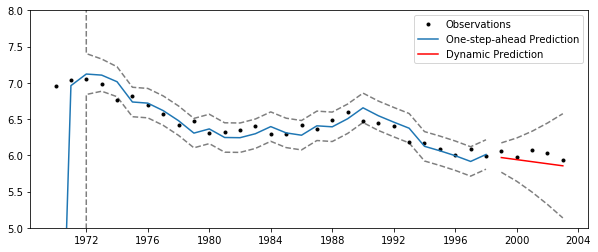

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))

# Perform dynamic prediction and forecasting
ndynamic = 5
predict_res = res.get_prediction(alpha=0.05, dynamic=df['lff'].shape[0]-ndynamic)

predict = predict_res.predicted_mean
ci = predict_res.conf_int(alpha=0.05)

# Plot the results
ax.plot(df['lff'], 'k.', label='Observations');
ax.plot(df.index[:-ndynamic], predict[:-ndynamic], label='One-step-ahead Prediction');
ax.plot(df.index[:-ndynamic], ci.iloc[:-ndynamic], 'k--', alpha=0.5);

ax.plot(df.index[-ndynamic:], predict[-ndynamic:], 'r', label='Dynamic Prediction');
ax.plot(df.index[-ndynamic:], ci.iloc[-ndynamic:], 'k--', alpha=0.5);

# Cleanup the image
ax.set_ylim((5, 8));
legend = ax.legend(loc='upper right');
legend.get_frame().set_facecolor('w')

### Citations

    Commandeur, Jacques J. F., and Siem Jan Koopman. 2007.
    An Introduction to State Space Time Series Analysis.
    Oxford ; New York: Oxford University Press.

    Durbin, James, and Siem Jan Koopman. 2012.
    Time Series Analysis by State Space Methods: Second Edition.
    Oxford University Press.